In [134]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
set.seed(999)

### Using Cholesterol, Fasting Blood Sugar, and Age to Classify Heart Disease Patients from Cleveland
**Introduction**  

Heart (cardiovascular) disease is a term displaying the wide range of heart conditions directly affecting the heart, associated blood vessels, and muscles surrounding the heart (Heart and Stroke Foundation Canada, n.d.). Such effects can result in long-term or short-term effects on the function of the heart itself spreading to other internal organs. Amongst the range of “heart” diseases coronary artery disease, commonly found in the United States is where the patients' blood vessels are narrowed and constricts the amount of blood supplying the heart. There is a multitude of prospective factors that may influence the likelihood of developing coronary artery disease or any variant of cardiovascular disease, including but not limited to, fasting blood sugar, cholesterol, and resting blood pressure.   

High levels of resting blood pressure are amongst one of the leading causes of cardiovascular disease resulting in stroke. This is due to the damaging of the lining of the arteries which can increase the probability of plaque buildup which narrows the arteries leading to the heart. Additionally, increased intake of cholesterol can build up inside of the blood vessels and restrict the flow to the heart, brain, lungs and kidneys (Centers for Disease Prevention and Control, 2022). Similarly, studies have observed and indicated fasting blood sugar as an underlying predictor in mortality of heart disease and the effects on the heart (National Library of Medicine, 2013). 

The objective of this project is to classify and categorize patients on their potential risk in developing heart disease.  

The question we will be addressing is: What is the likelihood of a patient at risk for heart disease based on their cholesterol, fasting blood sugar, and age? 

**THIS CELL WILL BE DELETED ONCE WE ARE SURE WE HAVE THE DATA WE NEED**  
Columns: 
      1. #3  (age)       
      2. #4  (sex)       
      3. #9  (cp)        
      4. #10 (trestbps)  
      5. #12 (chol)      
      6. #16 (fbs)       
      7. #19 (restecg)   
      8. #32 (thalach)   
      9. #38 (exang)     
      10. #40 (oldpeak)   
      11. #41 (slope)     
      12. #44 (ca)        
      13. #51 (thal)      
      14. #58 (num)       (the predicted attribute)
      
1. Age in years.
2. Sex of Patient: 1 = Male 0 = Female
3. CP:  chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of >              0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11.  slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14.  num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)


The columns in the data frame below represent the following:   

age: The age of the patient.  
                        
fasting_bs: Fasting blood sugar value in milligrams per deciliter (mg/dL) of blood.  
                        0 = Below 120 mg/dL  
                        1 = Above 120 mg/dL
                            
cholesterol: Serum Cholesterol in milligrams per deciliter (mg/dL) of blood. High cholesterol is considering to be over 240 mg/dL. 

heart_disease: Presence of heart disease in general.  
                        0 = No  
                        1 = Yes


Below we have read in the heart_disease data file and tidied the data into a table of only the columns we want to use. The column names and values in the heart_disease colunm have been renmaed for ease of understanding.

In [135]:
heart_data <- as_tibble(read.csv("heart.csv")) |>
    select(age, fbs, chol, target) |>

    rename(fast_bs = fbs,
           cholesterol = chol, 
           heart_disease = target) |>

    mutate(heart_disease = as_factor(heart_disease)) |>
    mutate(heart_disease = fct_recode(heart_disease, "Yes" = "1", "No" = "0"))
    
head(heart_data)

age,fast_bs,cholesterol,heart_disease
<int>,<int>,<int>,<fct>
52,0,212,No
53,1,203,No
70,0,174,No
61,0,203,No
62,1,294,No
58,0,248,Yes


Then the tidy data is split into training and testing data sets. The percentage of total rows from heart_data has also been calculated using the training_heart set to confirm a correct splitting ratio.

In [136]:
heart_data_split <- initial_split(heart_data, props = 0.75, strata = heart_disease)
training_heart <- training(heart_data_split)
testing_heart <- testing(heart_data_split)

split_percent <- round(nrow(training_heart)/ (nrow(training_heart) + nrow(testing_heart)) * 100)

split_percent

[1] 75

All three data sets, heart_data, training_heart and testing_heart are summarized and the ratio of positive and negative values for the heart_disease column are calculated and returned to ensure the split data sets are consistent with the original tidy data. 

In [137]:
num_obs_heart = nrow(heart_data)
num_obs_training = nrow(training_heart)
num_obs_testing = nrow(testing_heart)

heart_data_percent <- heart_data |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_total = round(n() / num_obs_heart * 100, 2))

training_heart_percent <- training_heart |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_training = round(n() / num_obs_training * 100, 2))

testing_heart_percent <- testing_heart |>
    group_by(heart_disease) |>
    summarize(total = n(),
             percentage_testing = round(n() / num_obs_testing * 100, 2))

heart_data_percent
training_heart_percent
testing_heart_percent

heart_disease,total,percentage_total
<fct>,<int>,<dbl>
No,499,48.68
Yes,526,51.32


heart_disease,total,percentage_training
<fct>,<int>,<dbl>
No,374,48.7
Yes,394,51.3


heart_disease,total,percentage_testing
<fct>,<int>,<dbl>
No,125,48.64
Yes,132,51.36


Below is some exploratory visualization. It shows there is a loose correlation between the age of a patient and their cholesterol in determining the presence of heart disease. 

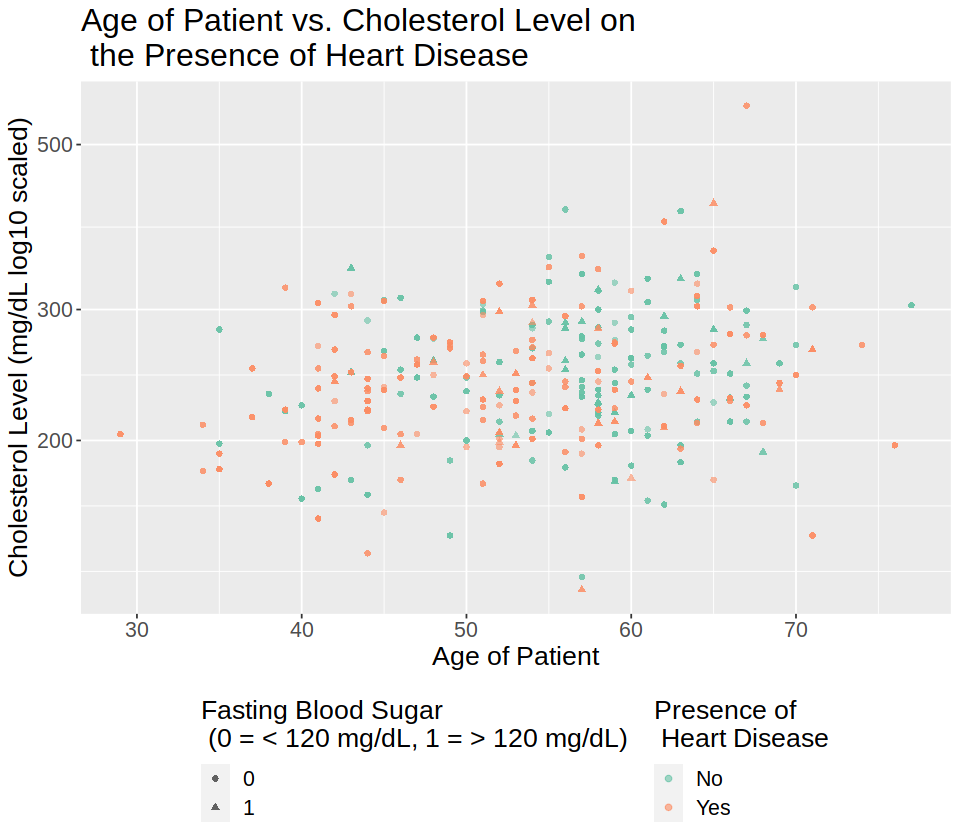

In [138]:
options(repr.plot.width = 8, repr.plot.height = 7)

heart_disease_plot <- training_heart |>
    ggplot(aes(x = age, y = cholesterol, color = heart_disease, shape = as_factor(fast_bs))) + 
        geom_point(alpha = 0.6) +
        ggtitle("Age of Patient vs. Cholesterol Level on \n the Presence of Heart Disease") +
        labs(x = "Age of Patient",
             y = "Cholesterol Level (mg/dL log10 scaled)",
             color = "Presence of \n Heart Disease", 
             shape = "Fasting Blood Sugar \n (0 = < 120 mg/dL, 1 = > 120 mg/dL)") +
        scale_y_log10(labels = comma) +
        scale_color_brewer(palette = "Set2") +
        theme(text = element_text(size = 16),
              legend.position = "bottom",
              legend.direction = "vertical")
            
heart_disease_plot

**Methods**  
We will analyze our data with the K – nearest neighbors classification algorithm, which predicts new observations given the K number of nearest neighbors and the category predictors. We will use the variables: cholesterol, fasting blood sugar, and age as our predictors to classify whether the patient is susceptible to heart disease. Because there are limited new observations, we will be using cross-validation to estimate the current data’s ability to predict unseen data. Cross-validation will also help determine the value of K that reduces under/overfitting. 

The points on the scatterplot will be colored according to the classification category. New data will be colored a different color from the categories to help recognize that it is unseen data and its nearest neighbors. 

**Expected Outcomes and Significance**  

Our expectation is that individuals who have been diagnosed with heart disease will, on average, exhibit higher levels of cholesterol, have low fasting blood sugar and tend to be older in age.  

Creating a K - nearest neighbors classification system for heart disease can simplify and improve the accuracy of diagnosis by health care professionals. This can ultimately lead to timely intervention and treatment.